<h1>Autocorrelation </h1>

In this code, we analyzed three commodity datasets: crude oil, gold, and silver. We began by testing the stationarity of each dataset using the Dickey-Fuller test. Then, we applied the Yeo-Johnson transformation to ensure a normal distribution. To determine the optimal lag values, we used the Ljung-Box test. We performed both Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) analyses, including a rolling ACF and PACF with a 100-window period. Additionally, we conducted a cross-correlation analysis between the commodities and performed the Durbin-Watson test to check for residual autocorrelation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Dataset/Data.xlsx')
df.set_index("Date", inplace = True)
column = ['Gold', 'Silver', 'Crude_Oil']
df = df[column]
# df = df.iloc[:, :-1]
df.head()

Gold  Silver  Crude_Oil
Date                                
1960-01-01  35.27  0.9137       1.63
1960-02-01  35.27  0.9137       1.63
1960-03-01  35.27  0.9137       1.63
1960-04-01  35.27  0.9137       1.63
1960-05-01  35.27  0.9137       1.63

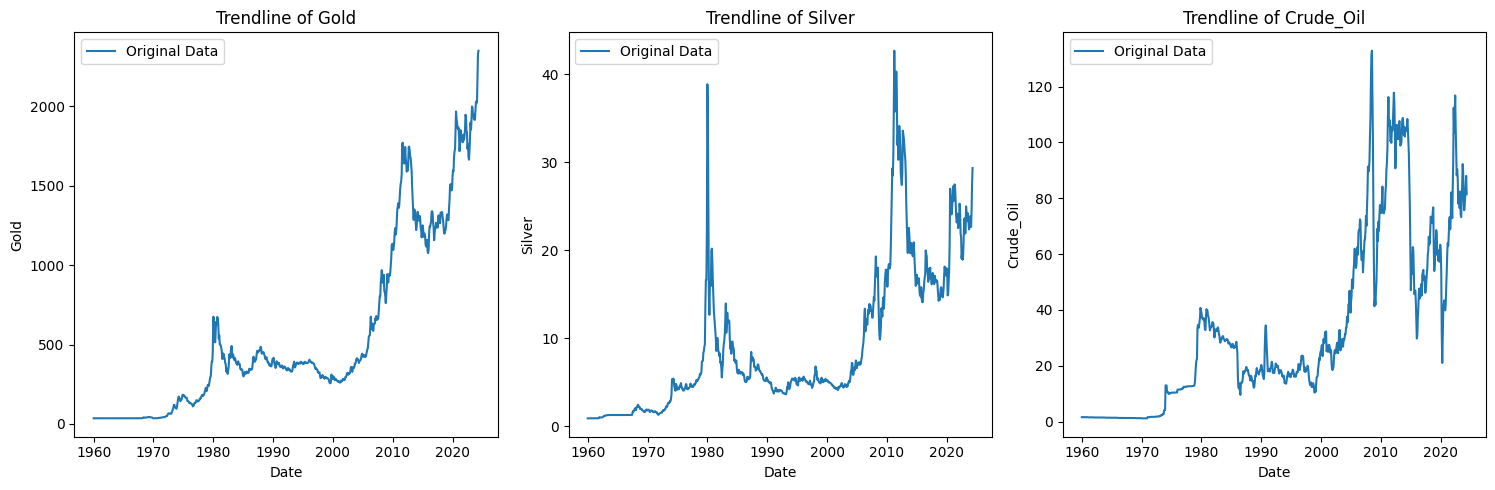

In [3]:
num_column = len(df.columns)
num_row_per_plot = 4
num_row = (num_column + num_row_per_plot - 1) // num_row_per_plot
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.lineplot(ax=axes[i], x=df.index, y = df[column], label='Original Data')
    axes[i].set_title(f'Trendline of {column}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [4]:
# Returns 
df_pct = df.pct_change()
df_pct = df_pct.dropna()
df_pct

Gold    Silver  Crude_Oil
Date                                     
1960-02-01  0.000000  0.000000   0.000000
1960-03-01  0.000000  0.000000   0.000000
1960-04-01  0.000000  0.000000   0.000000
1960-05-01  0.000000  0.000000   0.000000
1960-06-01  0.000000  0.000000   0.000000
...              ...       ...        ...
2024-01-01  0.003879 -0.040288   0.025793
2024-02-01 -0.005310 -0.011302   0.037023
2024-03-01  0.066611  0.082138   0.037216
2024-04-01  0.080370  0.121380   0.053452
2024-05-01  0.008441  0.067869  -0.074608

[772 rows x 3 columns]

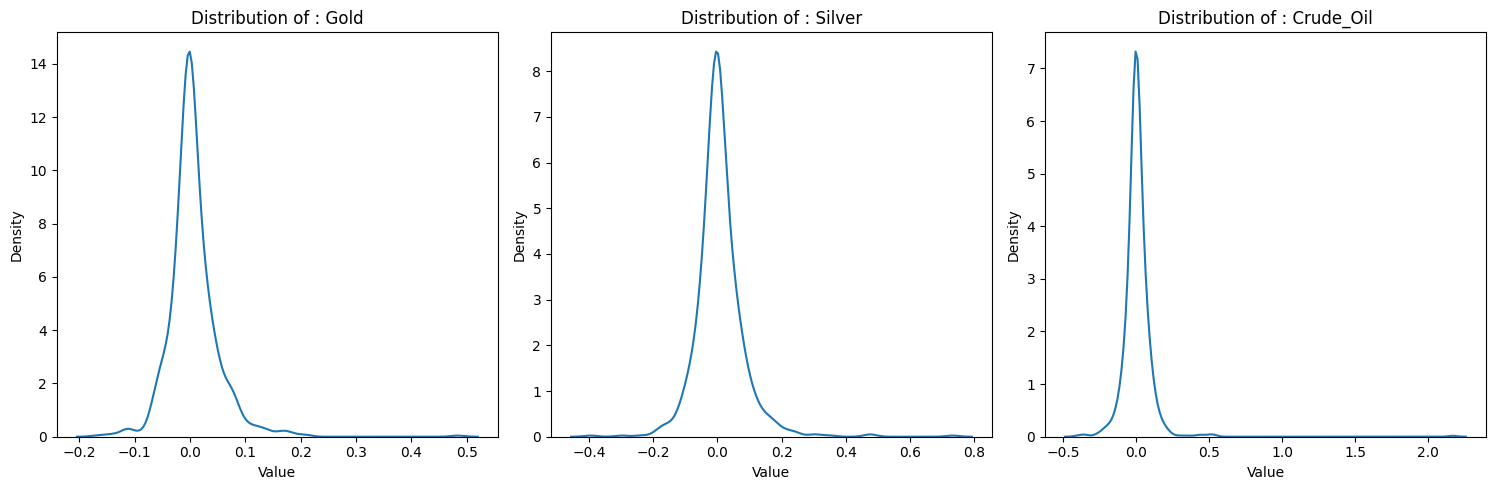

In [5]:
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()
for i, column in enumerate(df_pct.columns):
    sns.kdeplot(df_pct[column], ax=axes[i])
    axes[i].set_title(f'Distribution of : {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(df_pct)
df = pd.DataFrame(transformed_data, index = df_pct.index, columns=df_pct.columns)
df

Gold    Silver  Crude_Oil
Date                                     
1960-02-01 -0.066527 -0.034803  -0.014715
1960-03-01 -0.066527 -0.034803  -0.014715
1960-04-01 -0.066527 -0.034803  -0.014715
1960-05-01 -0.066527 -0.034803  -0.014715
1960-06-01 -0.066527 -0.034803  -0.014715
...              ...       ...        ...
2024-01-01  0.027005 -0.621886   0.287758
2024-02-01 -0.196946 -0.195154   0.414380
2024-03-01  1.356311  1.036594   0.416529
2024-04-01  1.607342  1.496708   0.594360
2024-05-01  0.135144  0.861501  -0.988740

[772 rows x 3 columns]

Performed Yeo Johnson Transformation to make distribution normal

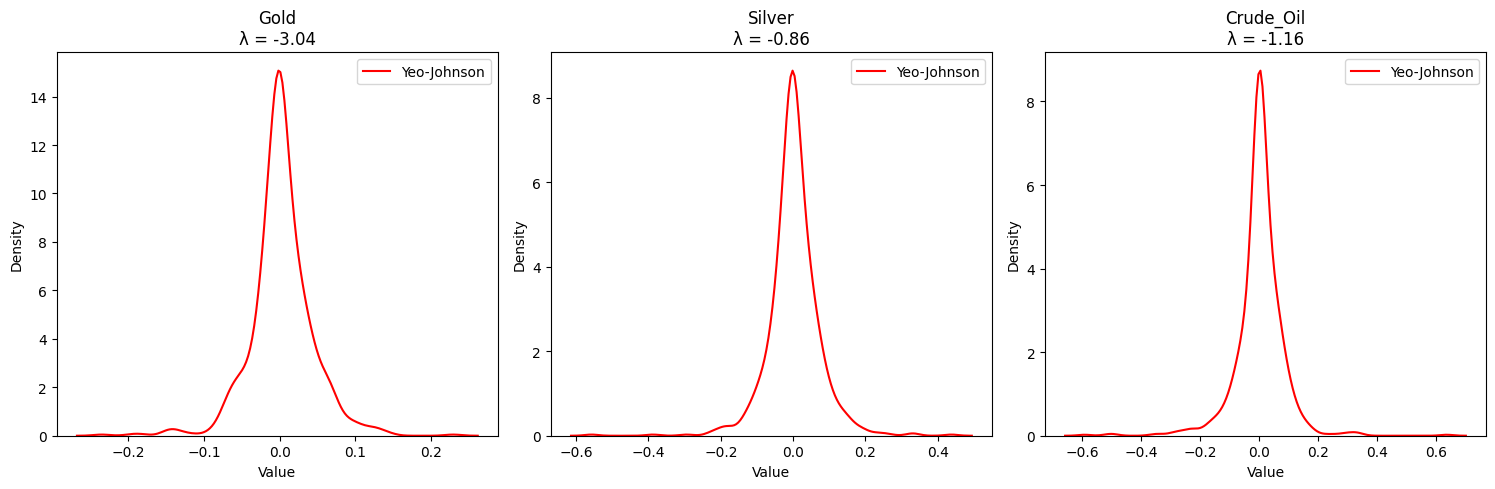

In [7]:
# Yeo-Johnson Transformation - To make distribution normal
from scipy import stats

fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df_pct.columns):
    transformed_data, lambda_param = stats.yeojohnson(df_pct[column])
    sns.kdeplot(transformed_data, ax=axes[i], color='red', label='Yeo-Johnson')
    axes[i].set_title(f'{column}\nλ = {lambda_param:.2f}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

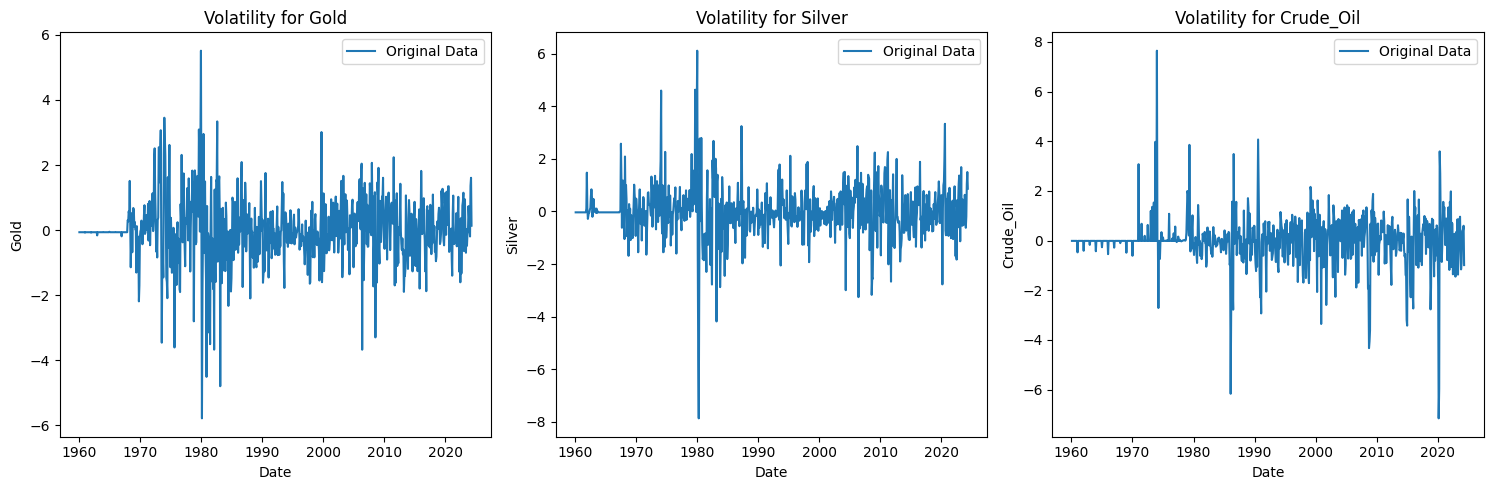

In [8]:
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.lineplot(ax=axes[i], x=df.index, y=df[column], label='Original Data')
    axes[i].set_title(f'Volatility for {column}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

<h3>Dickery Fuller Test with second order differencing</h3>

We performed a Dickey-Fuller test to check for stationarity and applied first and second-order differencing methods to make the data stationary if it was found to be non-stationary.

No constant, no trend:
$\Delta y_t = \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t$

Constant only:
$\Delta y_t = \alpha + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t$

Constant and trend:
$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t$

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF statistics for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print(f"{column_name} is stationary")
        print('')
        return True
    else:
        print(f"{column_name} is not stationary")
        print('')
        return False
    print('')

def make_stationary(df):
    stationary_df = pd.DataFrame()
    for column in df.columns:
        series = df[column]
        is_stationary = adf_test(series, column)
        differencing_count = 0
        while not is_stationary:
            series = series.diff().dropna()
            differencing_count += 1
            is_stationary = adf_test(series, column)
            if differencing_count > 2: 
                break
        stationary_df[column] = series
    return stationary_df

stationary_volatility_df = make_stationary(df)

ADF statistics for Gold: -5.224524625536097
p-value for Gold: 7.833077712964633e-06
Critical Value 1%: -3.439099096730074
Critical Value 5%: -2.8654013553540745
Critical Value 10%: -2.568826193777778
Gold is stationary

ADF statistics for Silver: -19.277484721097352
p-value for Silver: 0.0
Critical Value 1%: -3.4388710830827125
Critical Value 5%: -2.8653008652386576
Critical Value 10%: -2.568772659807725
Silver is stationary

ADF statistics for Crude_Oil: -17.9825935730316
p-value for Crude_Oil: 2.7715509363691153e-30
Critical Value 1%: -3.4388710830827125
Critical Value 5%: -2.8653008652386576
Critical Value 10%: -2.568772659807725
Crude_Oil is stationary



<h3>Ljung-Box test with Box-Pierce test

The Ljung-Box test (also known as acorr_ljungbox) is a statistical test used to check whether any group of autocorrelations of a time series are significantly different from zero. In simpler terms, it tests whether a time series shows evidence of serial correlation (i.e., whether past values have an influence on current values) over a specified lag.

$Q = n(n + 2) \sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n - k}$

$Q$ is the Ljung-Box test statistic,

$n$ is the number of observations,

$h$ is the number of lags being tested (chosen by the user),

$\hat{\rho}_k$ is the sample autocorrelation at lag $k$.

The results reveal that both the Ljung-Box and Box-Pierce test statistics for Crude oil, Gold and Silver are highly significant across various lags (30), indicating strong evidence of autocorrelation in the time series data. This suggests that all three commodities exhibit significant patterns and dependence over time.

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for i, column in enumerate(df.columns):
    print(column)
    lb_test = acorr_ljungbox(df[column], return_df=True, lags=30, boxpierce=True)
    print(lb_test)

Gold
       lb_stat     lb_pvalue     bp_stat     bp_pvalue
1    42.109573  8.629970e-11   41.946357  9.381198e-11
2    43.155350  4.255345e-10   42.986730  4.629671e-10
3    43.174256  2.260023e-09   43.005514  2.454377e-09
4    44.465413  5.135208e-09   44.286662  5.593703e-09
5    44.635324  1.720875e-08   44.455036  1.872308e-08
6    49.222395  6.729521e-09   48.994695  7.474198e-09
7    54.596188  1.792390e-09   54.306003  2.045855e-09
8    63.998772  7.610766e-11   63.587107  9.176642e-11
9    70.809766  1.056186e-11   70.301303  1.328986e-11
10   73.366470  9.884453e-12   72.818369  1.262758e-11
11   91.229573  9.569275e-15   90.381445  1.403518e-14
12   99.109104  8.319889e-16   98.118453  1.299840e-15
13  100.075321  1.604196e-15   99.065944  2.516214e-15
14  106.107081  3.170245e-16  104.973017  5.247150e-16
15  106.832424  6.523841e-16  105.682428  1.082169e-15
16  114.049418  7.589469e-17  112.731586  1.354327e-16
17  114.210459  1.937638e-16  112.888673  3.444408e-16
18  1

<h3>ACF and PACF plot

We plotted the ACF and PACF with 30 lags for Crude Oil, Gold, and Silver. The analysis reveals that Gold exhibits more significant positive and negative correlations above the threshold compared to Silver and Crude Oil. This indicates that Gold's time series shows stronger and more distinct autocorrelation patterns than the other commodities.

We can see that the Crude Oil, and Silver ACF plot, at 1 are above the significance threshold while all other lags fall under the non-significant threshold, it indicates that the autocorrelation at these early lags is significant, suggesting a strong immediate correlation with past values. 

Beyond the 1st lag of Crude oil PACF plot, there is no direct significant correlation with other 28 lags. Crude Oil time series may not exhibit a strong autoregressive structure beyond the immediate past. This typically suggests that an AR(1) model might be sufficient to capture the main autoregressive effect in the series.

The PACF plot for Silver shows that lag 1 is positively correlated, and lags 2 is negatively correlated. It indicates that Silver's time series has significant direct correlations at these lags, suggesting a mix of positive and negative dependencies in the immediate past.

The PACF of Gold shows that lags 1, 7, and 12 have significant positive correlations, indicating notable direct relationships with the current value. Additionally, lag 2 has a significant negative correlation, suggesting an inverse relationship at this lag after accounting for other lags.

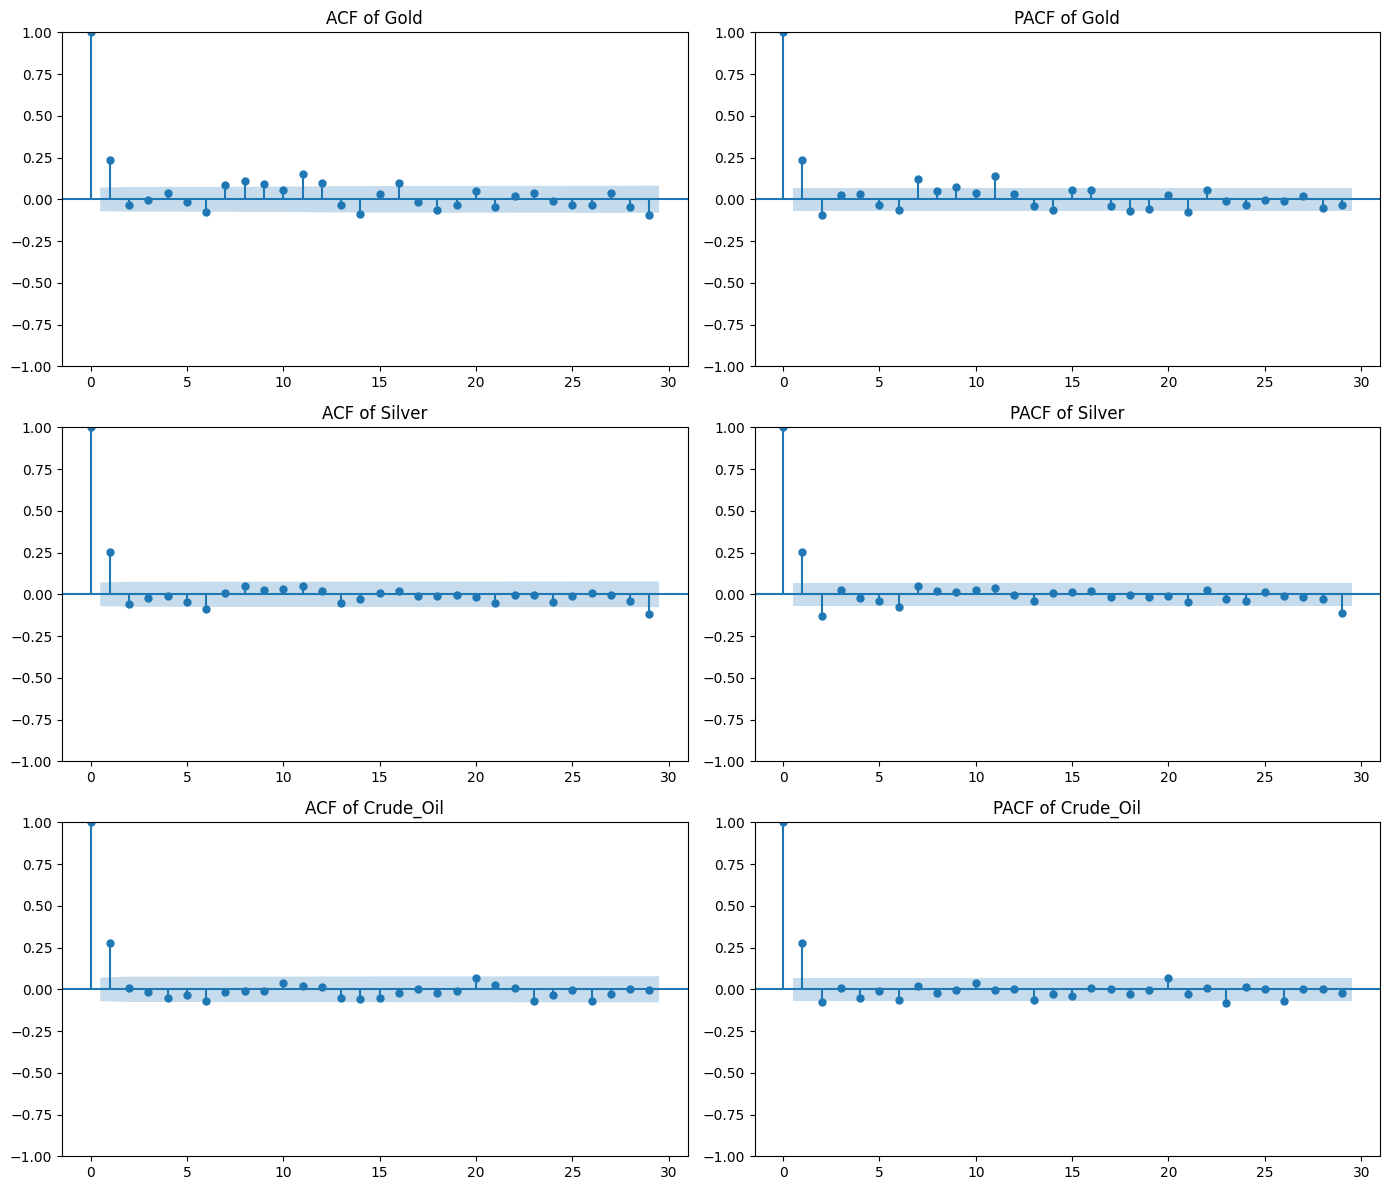

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
columns = ['Gold', 'Silver', 'Crude_Oil']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
for i, column in enumerate(columns):
    plot_acf(df[column], ax=axes[i, 0], title=f'ACF of {column}')
    plot_pacf(df[column], ax=axes[i, 1], title=f'PACF of {column}')

plt.tight_layout()
# plt.savefig('ACF and PACF.png', dpi=300)
plt.show()

<h3>Durbin-Watson statistic </h3>

In [12]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

X = df[['Silver', 'Gold']]
y = df['Crude_Oil']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
residuals = model.resid

dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_statistic}')

Durbin-Watson statistic: 1.4783341761665816


The Durbin-Watson statistic of 1.478 suggests that there is positive autocorrelation in the residuals of your regression model.

DW ≈ 2: Indicates no autocorrelation (ideal).
DW < 2: Suggests positive autocorrelation (residuals are correlated in a positive direction, meaning that if a residual is positive, the next residual is likely to be positive too).
DW > 2: Indicates negative autocorrelation (residuals alternate between positive and negative values).

<h3>Rolling ACF and PACF plot

The rolling PACF and ACF plots with a 100-period window and 30 lags for Crude Oil, Gold, and Silver display how the autocorrelations and partial autocorrelations of the time series evolve over time. By applying a rolling window, these plots illustrate the dynamics and changes in correlation patterns across different periods, allowing us to observe variations in autocorrelation structures and identify any shifts or trends in the relationships between observations at different lags. This approach helps in understanding how the time series' behavior evolves and provides insights into potential structural changes or anomalies in the data.

In [13]:
from statsmodels.tsa.stattools import acf, pacf

column = ['Gold', 'Silver', 'Crude_Oil']
window_size = 100 
max_lag = 30     

def rolling_acf_pacf(series, window_size, max_lag):
    acf_values = []
    pacf_values = []
    
    for start in range(len(series) - window_size + 1):
        end = start + window_size
        window = series[start:end]
        acf_result = acf(window, nlags=max_lag, fft=True)
        pacf_result = pacf(window, nlags=max_lag)
        acf_values.append(acf_result)
        pacf_values.append(pacf_result)
    
    return np.array(acf_values), np.array(pacf_values)

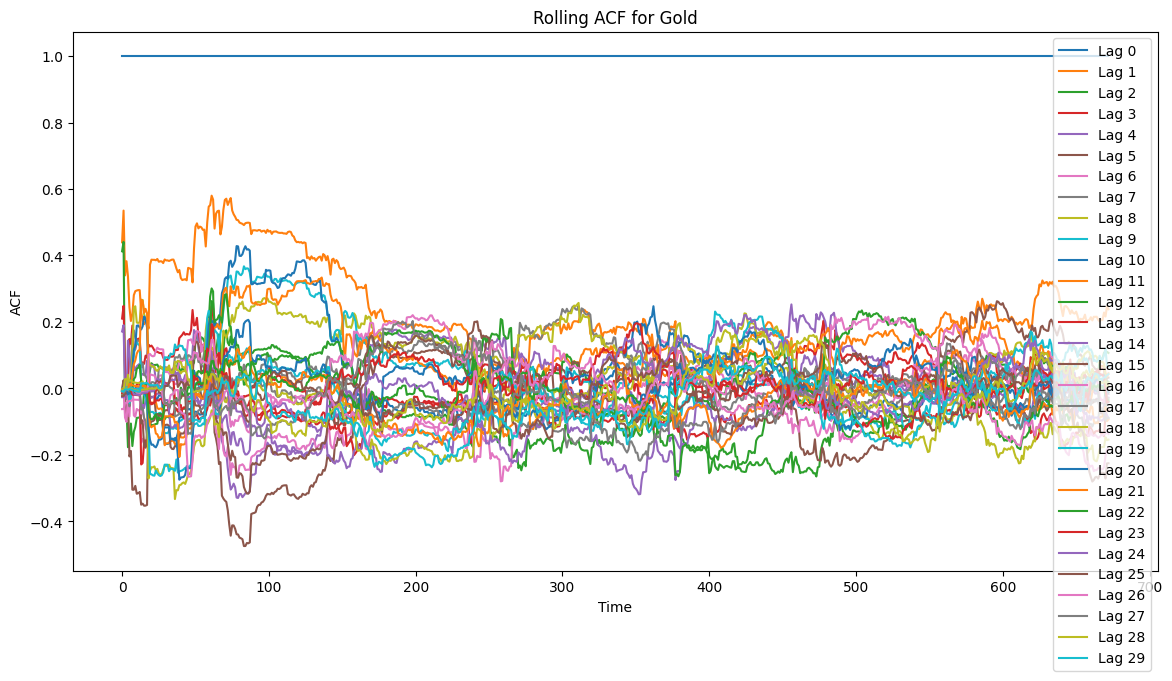

In [36]:
acf_rolling, pacf_rolling = rolling_acf_pacf(df['Gold'], window_size, max_lag)

plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(acf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling ACF for Gold')
plt.xlabel('Time')
plt.ylabel('ACF')
plt.legend()
# plt.savefig('Rolling ACF for Gold', dpi=300)
plt.show()

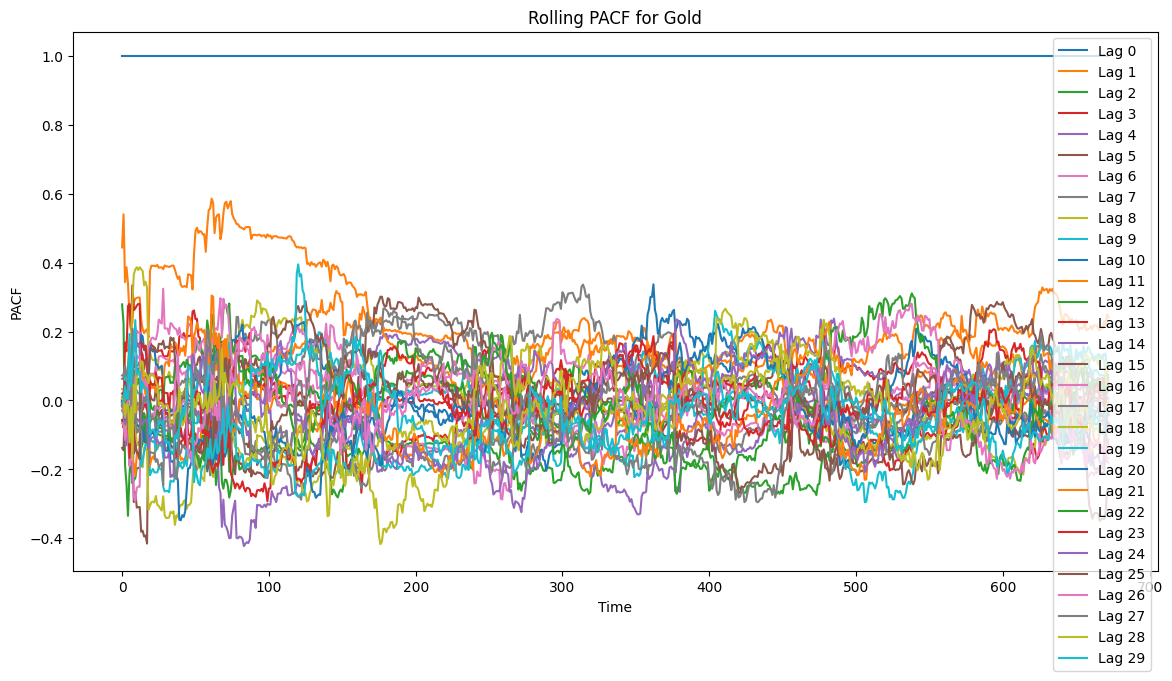

In [37]:
plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(pacf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling PACF for Gold')
plt.xlabel('Time')
plt.ylabel('PACF')
plt.legend()
# plt.savefig('Rolling PACF for Gold', dpi=300)
plt.show()

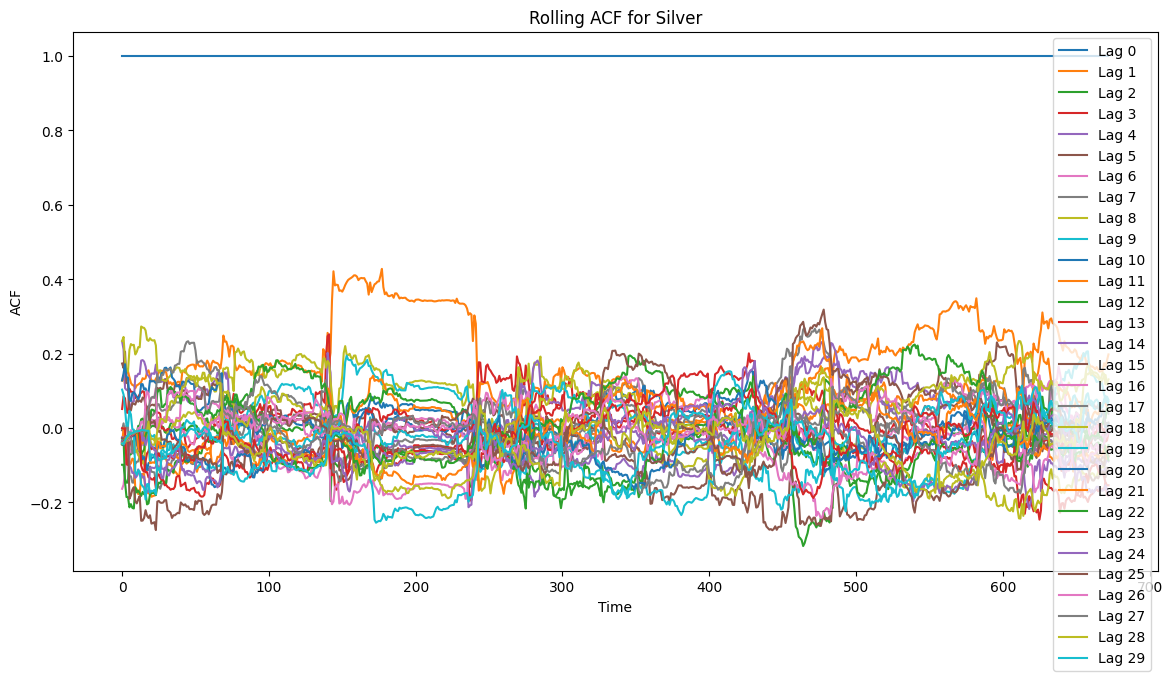

In [16]:
acf_rolling, pacf_rolling = rolling_acf_pacf(df['Silver'], window_size, max_lag)

plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(acf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling ACF for Silver')
plt.xlabel('Time')
plt.ylabel('ACF')
plt.legend()
plt.show()

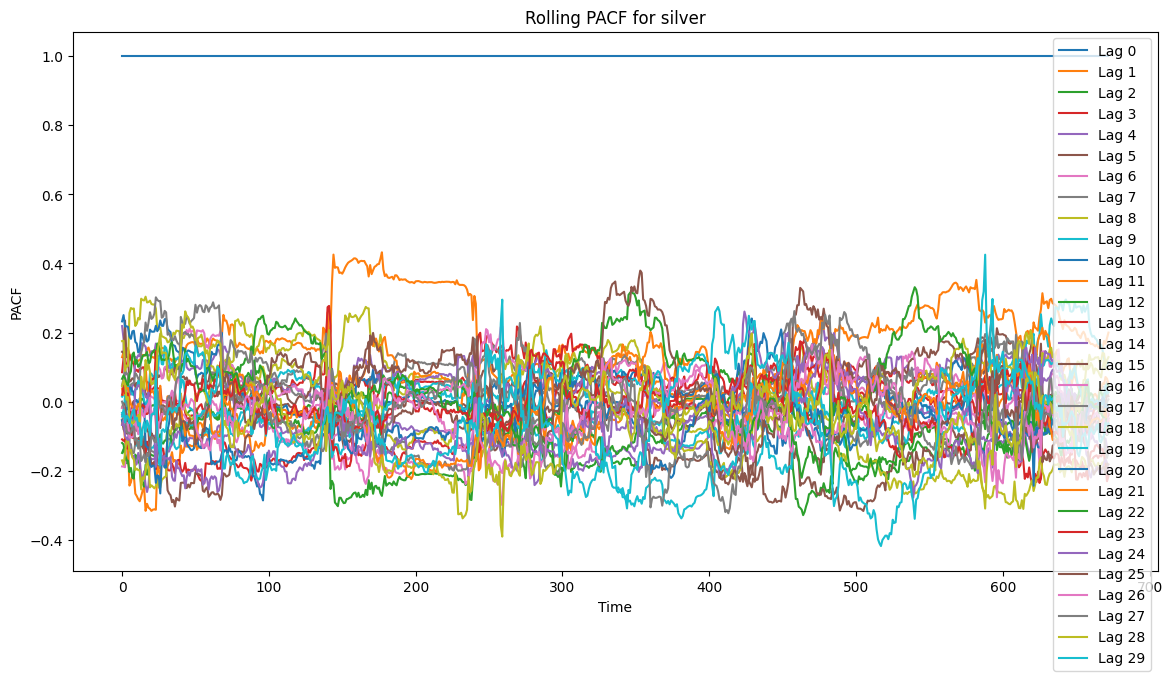

In [17]:
plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(pacf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling PACF for silver')
plt.xlabel('Time')
plt.ylabel('PACF')
plt.legend()
plt.show()

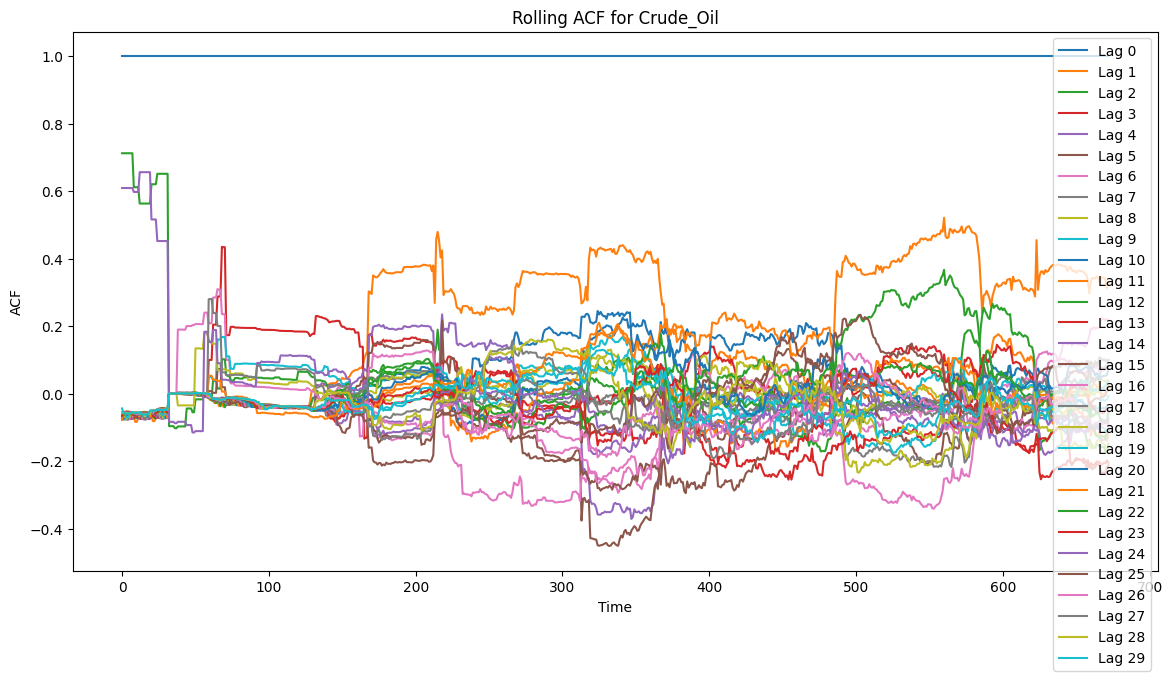

In [18]:
acf_rolling, pacf_rolling = rolling_acf_pacf(df['Crude_Oil'], window_size, max_lag)

plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(acf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling ACF for Crude_Oil')
plt.xlabel('Time')
plt.ylabel('ACF')
plt.legend()
plt.show()

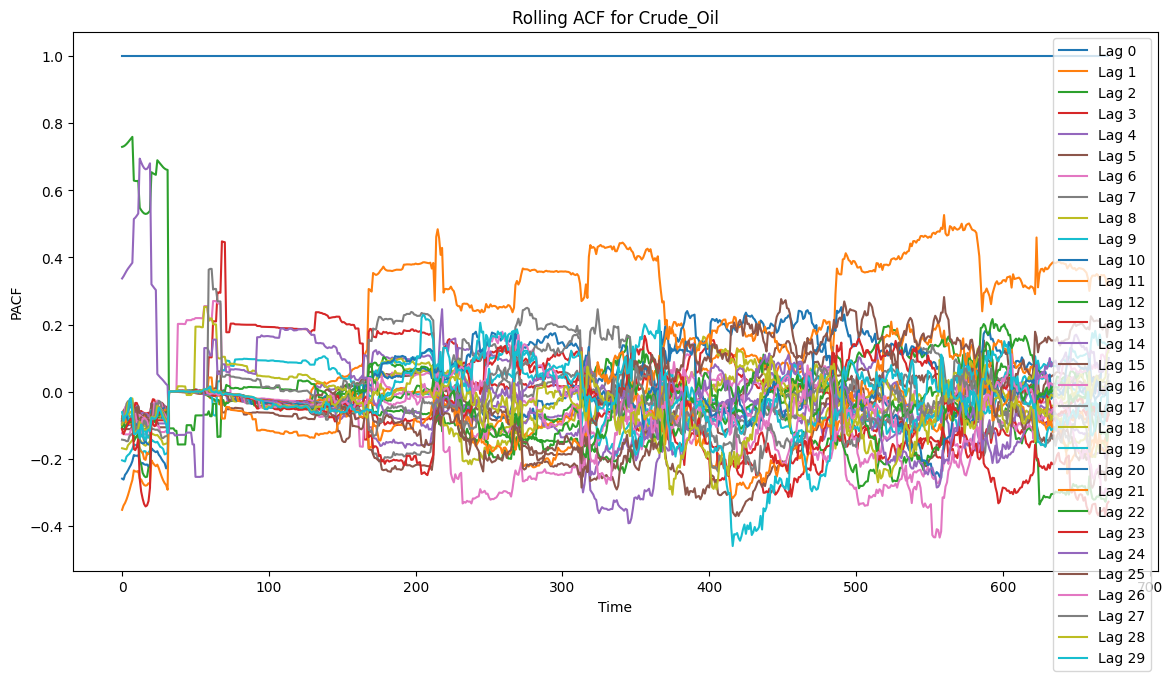

In [19]:
acf_rolling, pacf_rolling = rolling_acf_pacf(df['Crude_Oil'], window_size, max_lag)

plt.figure(figsize=(14, 7))
for lag in range(max_lag):
    plt.plot(pacf_rolling[:, lag], label=f'Lag {lag}')
plt.title('Rolling ACF for Crude_Oil')
plt.xlabel('Time')
plt.ylabel('PACF')
plt.legend()
plt.show()

<h3>Cross Correlation

In [34]:
from statsmodels.tsa.stattools import ccf

def cross_correlation(series1, series2, max_lag):
    return ccf(series1, series2, adjusted=False)[:max_lag + 1]

def plot_cross_correlation(series1, series2, label1, label2, max_lag):
    ccf_values = cross_correlation(series1, series2, max_lag)
    plt.figure(figsize=(12, 6))
    plt.stem(range(max_lag + 1), ccf_values)
    plt.title(f'Cross-Correlation between {label1} and {label2}')
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.grid()
    # plt.savefig('Cross Correlations.png', dpi=300)
    plt.show()

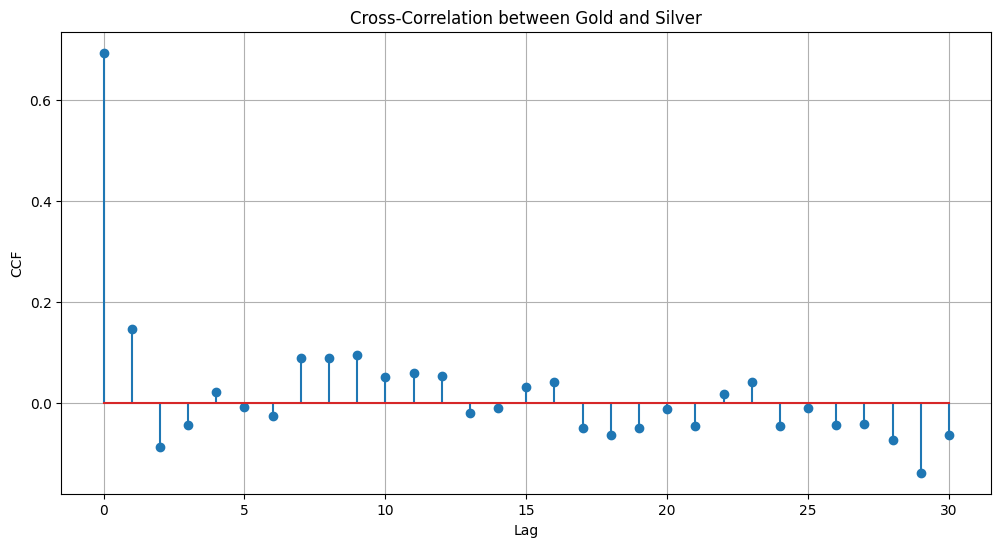

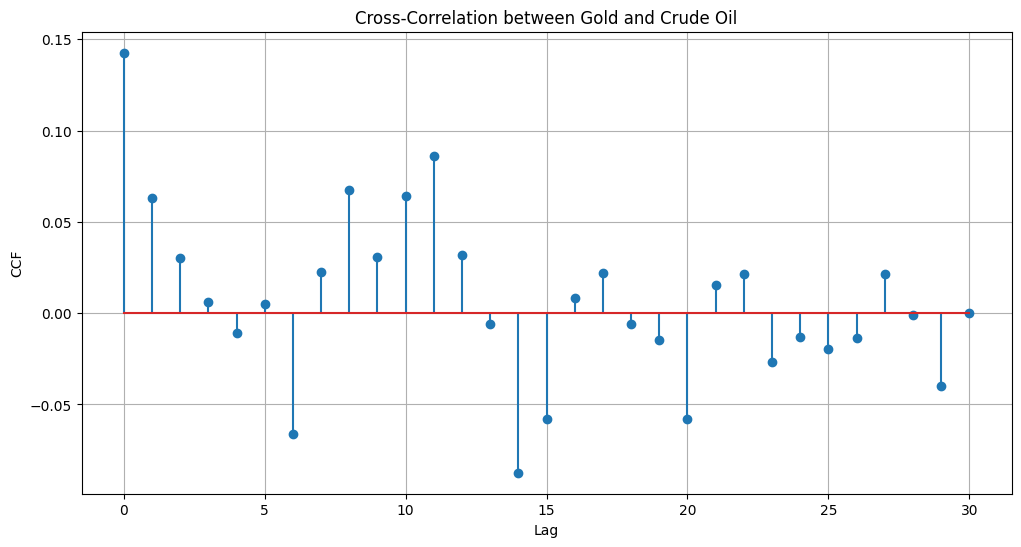

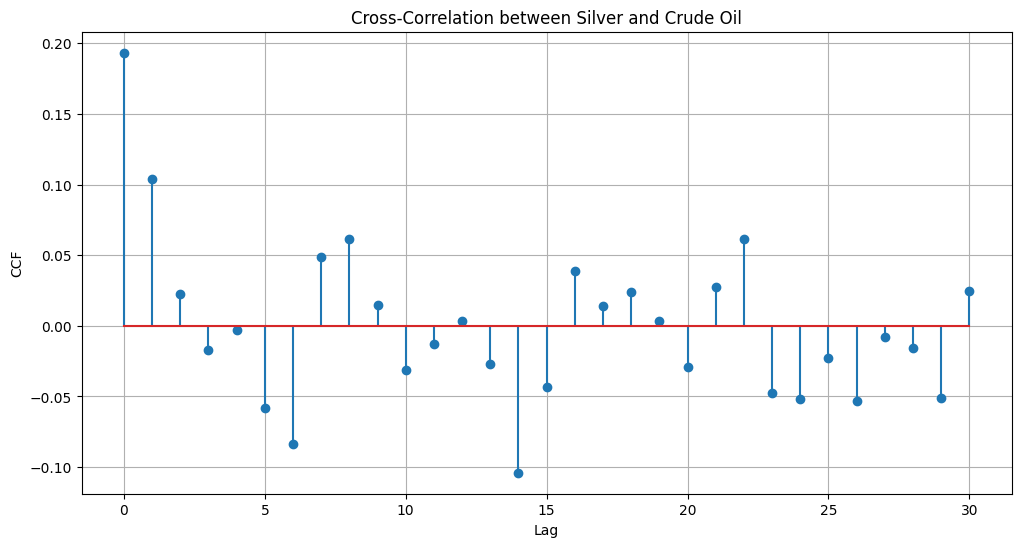

In [35]:
max_lag = 30

plot_cross_correlation(df['Gold'], df['Silver'], 'Gold', 'Silver', max_lag)
plot_cross_correlation(df['Gold'], df['Crude_Oil'], 'Gold', 'Crude Oil', max_lag)
plot_cross_correlation(df['Silver'], df['Crude_Oil'], 'Silver', 'Crude Oil', max_lag)

Gold and Silver: The cross-correlation at lag 0 is 0.6, suggesting a strong positive correlation between Gold and Silver at this lag. For other lags, the correlations range between 0.2 and -0.2, indicating weaker correlations that fluctuate around zero. This implies that Gold and Silver are closely related at the current time period but have only weak and variable relationships at other lags.

Gold and Crude Oil: The cross-correlation at lag 0 is 0.15, showing a mild positive correlation between Gold and Crude Oil at this lag. Most of the other lags show very weak correlations, mostly between 0.10 and -0.10, with the majority being even closer to zero (between 0.05 and -0.05). This suggests that Gold and Crude Oil have a weak and inconsistent relationship over different time lags.

Silver and Crude Oil: The cross-correlation at lag 0 is 0.2, indicating a weak positive correlation between Silver and Crude Oil at this lag. For other lags, the correlations lie between 0.10 and -0.10, with the majority of lags showing very weak correlations around 0.05 and -0.05. This means Silver and Crude Oil have a minor and variable relationship over time.

In [22]:
import pmdarima as pm

def fit_auto_arma(series):
    model = pm.auto_arima(series, seasonal=False, stepwise=True, trace=True)
    return model

In [23]:
gold_auto_arma = fit_auto_arma(df['Gold'])
crude_oil_auto_arma = fit_auto_arma(df['Crude_Oil'])
silver_auto_arma = fit_auto_arma(df['Silver'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2148.793, Time=3.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2192.841, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2151.767, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2145.262, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2146.728, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2146.633, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2148.950, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2147.262, Time=0.28 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 4.674 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2130.404, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2192.841, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2132.082, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2126.909, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=212

In [24]:
def durbin_watson_statistic(residuals):
    return sm.stats.durbin_watson(residuals)

gold_residuals = df['Gold'] - gold_auto_arma.predict_in_sample()
crude_oil_residuals = df['Crude_Oil'] - crude_oil_auto_arma.predict_in_sample()
silver_residuals = df['Silver'] - silver_auto_arma.predict_in_sample()

In [25]:
gold_dw = durbin_watson_statistic(gold_residuals)
crude_oil_dw = durbin_watson_statistic(crude_oil_residuals)
silver_dw = durbin_watson_statistic(silver_residuals)

print("Gold Durbin-Watson Statistic:")
print(gold_dw)

print("\nCrude Oil Durbin-Watson Statistic:")
print(crude_oil_dw)

print("\nSilver Durbin-Watson Statistic:")
print(silver_dw)

Gold Durbin-Watson Statistic:
2.0143985483246327

Crude Oil Durbin-Watson Statistic:
1.996259013047527

Silver Durbin-Watson Statistic:
2.0287314839618062


The Durbin-Watson statistics for Gold (2.014), Crude Oil (1.996), and Silver (2.029) are all close to 2, indicating that the residuals from the ARMA models for these commodities exhibit minimal autocorrelation. This suggests that the models fit the data well and that the residuals behave as white noise. Overall, the ARMA models for Gold, Crude Oil, and Silver appear to be appropriately specified.

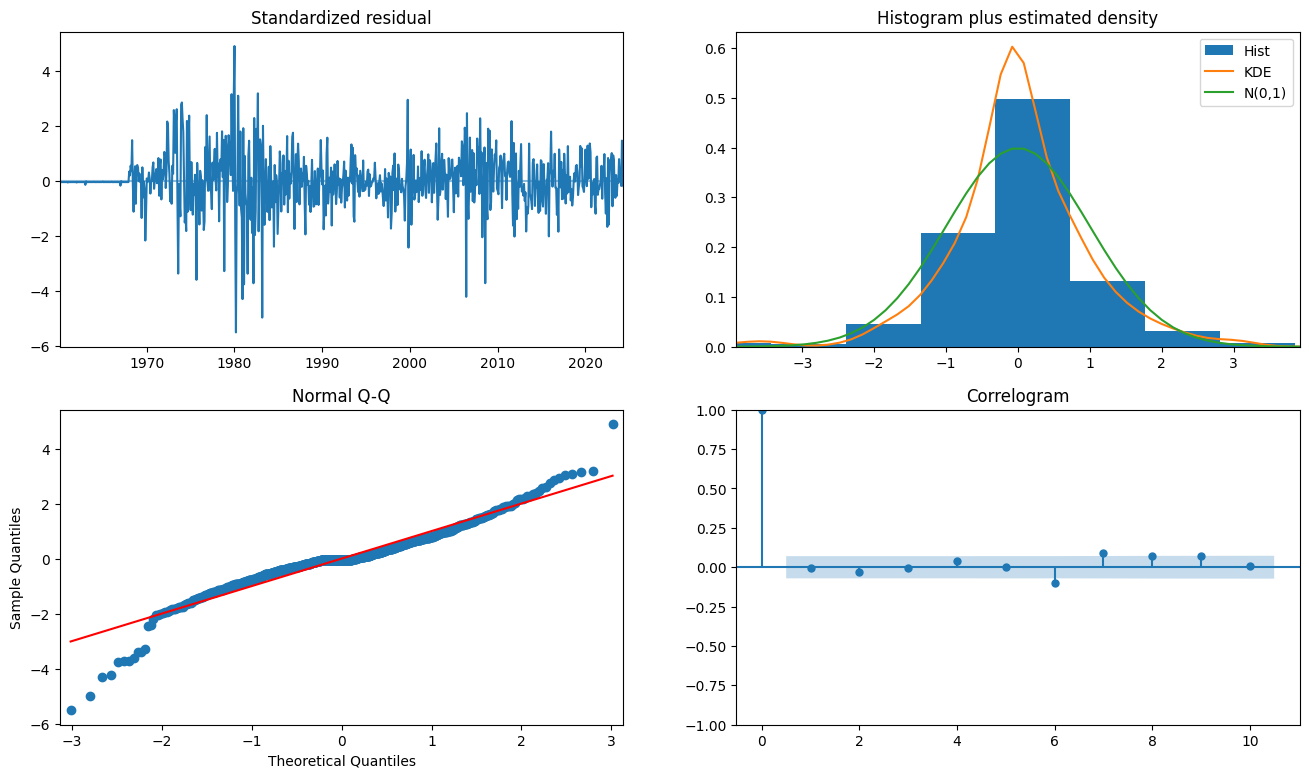

In [26]:
plt.rcParams["figure.figsize"] = (16, 9)
gold_auto_arma.plot_diagnostics()
plt.show()

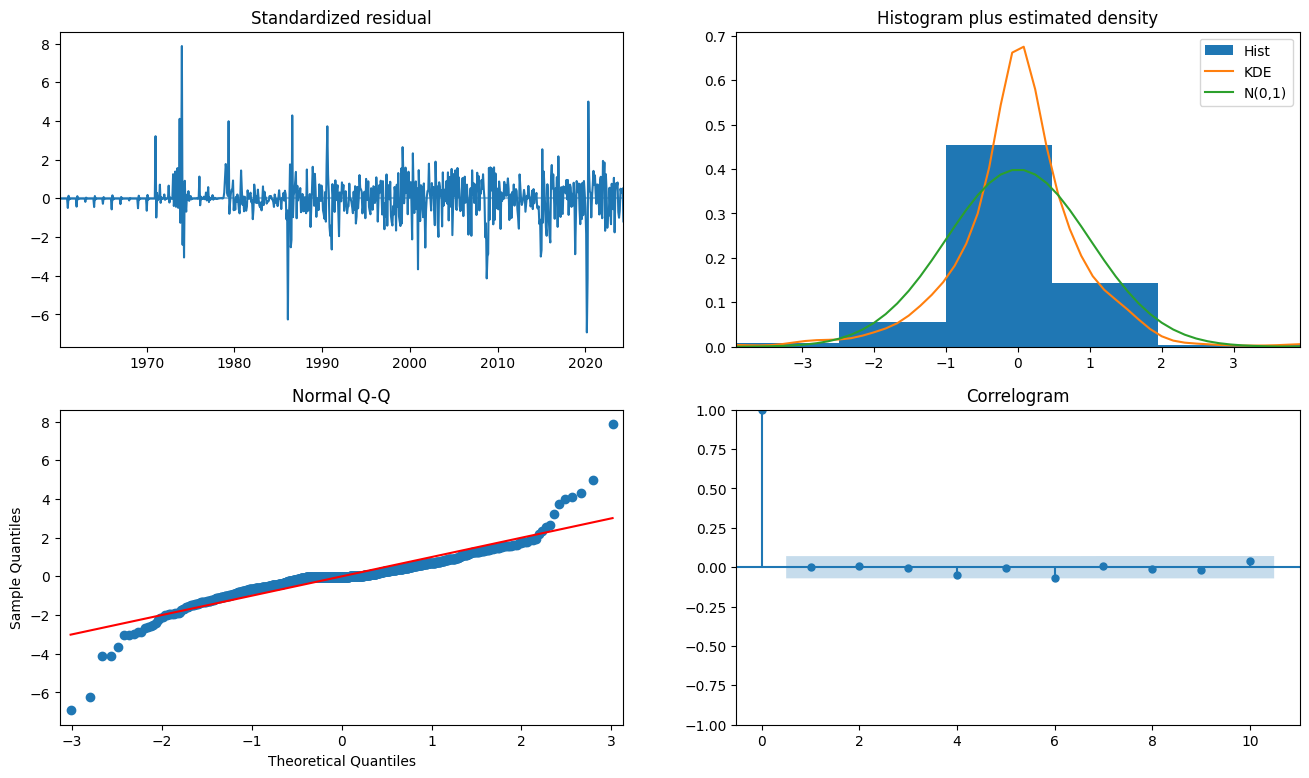

In [27]:
crude_oil_auto_arma.plot_diagnostics()
plt.show()

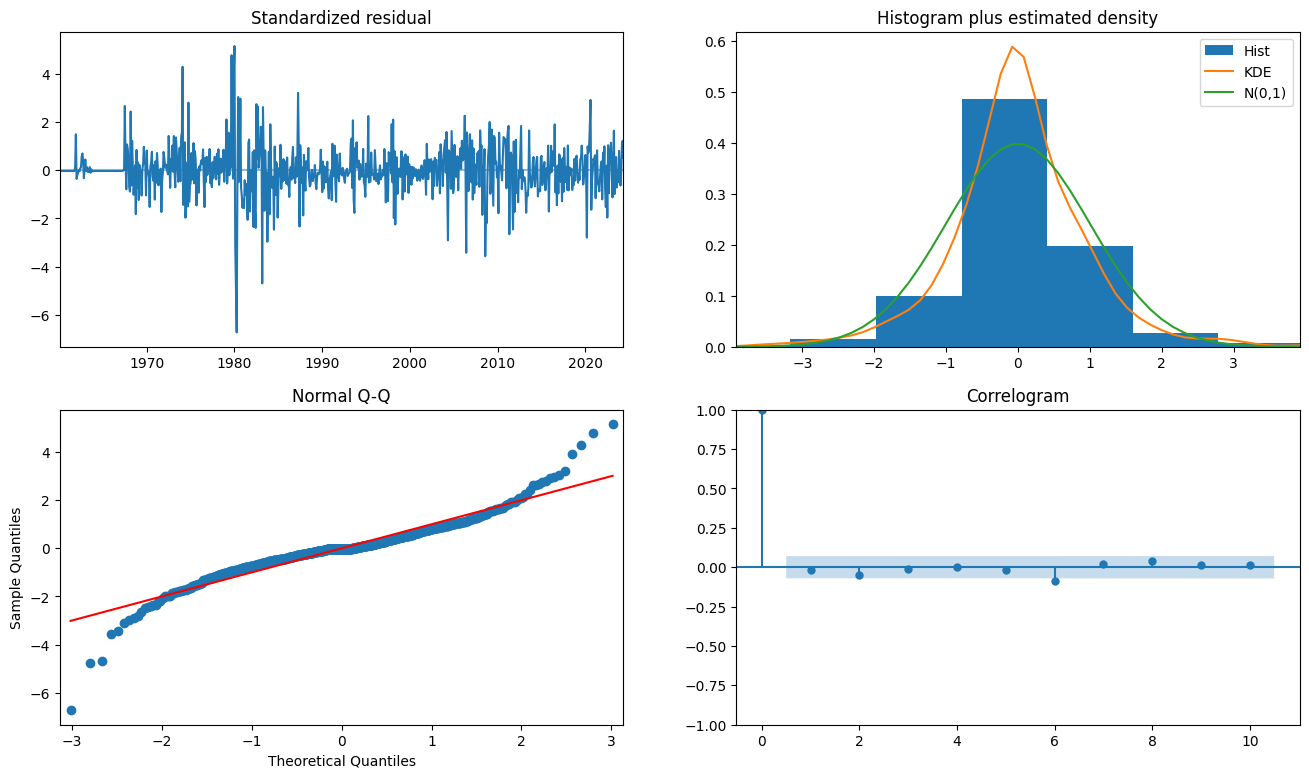

In [28]:
silver_auto_arma.plot_diagnostics()
plt.show()

In [29]:
n_periods=1
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')
def forecast_and_plot(model):
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    forecast_df = pd.DataFrame({
        'Forecast': forecast,
    }, index=forecast_dates)
    print(forecast_df)

In [30]:
forecast_and_plot(gold_auto_arma)

            Forecast
2024-06-01 -0.050925


In [31]:
forecast_and_plot(crude_oil_auto_arma)

            Forecast
2024-06-01 -0.344635


In [32]:
forecast_and_plot(silver_auto_arma)

            Forecast
2024-06-01  0.152848


<h1>Heteroskedasticity

[*********************100%%**********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_15992\1948464155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_data['Time'] = range(len(aapl_data))


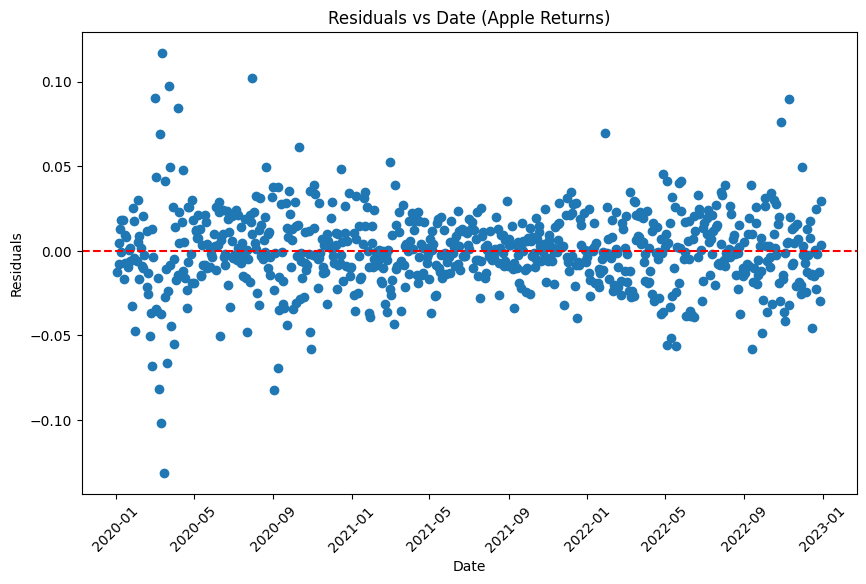

In [38]:
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import numpy as np  # Add this line to import numpy

# Download real stock data for Apple (AAPL)
aapl_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Calculate daily returns, and drop NaN values
aapl_data['Returns'] = aapl_data['Adj Close'].pct_change()
aapl_data = aapl_data.dropna()  # Remove rows with NaN values

# Prepare the data for regression (simple linear model with time as independent variable)
aapl_data['Time'] = range(len(aapl_data))
X = sm.add_constant(aapl_data['Time'])
y = aapl_data['Returns']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Plot residuals vs date (using actual dates for x-axis)
plt.figure(figsize=(10,6))
plt.scatter(aapl_data.index, model.resid)
plt.title('Residuals vs Date (Apple Returns)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.show()

In [39]:
# Create a DataFrame with the residuals and other components
aapl_data['Predicted_Returns'] = model.fittedvalues
aapl_data['Residuals'] = model.resid

# Select the relevant columns (Date, Actual Returns, Predicted Returns, Residuals)
residuals_table = aapl_data[['Returns', 'Predicted_Returns', 'Residuals']]

# Display the table
residuals_table.head(30)  # Display the first few rows of the table

C:\Users\HP\AppData\Local\Temp\ipykernel_15992\1892762514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_data['Predicted_Returns'] = model.fittedvalues
C:\Users\HP\AppData\Local\Temp\ipykernel_15992\1892762514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_data['Residuals'] = model.resid


Returns  Predicted_Returns  Residuals
Date                                              
2020-01-03 -0.009722           0.003125  -0.012848
2020-01-06  0.007968           0.003120   0.004848
2020-01-07 -0.004703           0.003114  -0.007817
2020-01-08  0.016086           0.003109   0.012978
2020-01-09  0.021241           0.003103   0.018138
2020-01-10  0.002260           0.003097  -0.000837
2020-01-13  0.021364           0.003092   0.018273
2020-01-14 -0.013503           0.003086  -0.016589
2020-01-15 -0.004286           0.003081  -0.007366
2020-01-16  0.012526           0.003075   0.009451
2020-01-17  0.011071           0.003070   0.008001
2020-01-21 -0.006777           0.003064  -0.009841
2020-01-22  0.003570           0.003058   0.000511
2020-01-23  0.004816           0.003053   0.001763
2020-01-24 -0.002882           0.003047  -0.005929
2020-01-27 -0.029405           0.003042  -0.032447
2020-01-28  0.028289           0.003036   0.025253
2020-01-29  0.020932           0.003031   0.017902
2020-01-30 -0.001449           0.003025  -0.004474
2020-01-31 -0.044339           0.003019  -0.047358
2020-02-03 -0.002746           0.003014  -0.005760
2020-02-04  0.033014           0.003008   0.030006
2020-02-05  0.008154           0.003003   0.005151
2020-02-06  0.011697           0.002997   0.008700
2020-02-07 -0.013593           0.002992  -0.016584
2020-02-10  0.004750           0.002986   0.001764
2020-02-11 -0.006033           0.002980  -0.009014
2020-02-12  0.023748           0.002975   0.020773
2020-02-13 -0.007121           0.002969  -0.010090
2020-02-14  0.000246           0.002964  -0.002718

<h3>Returns

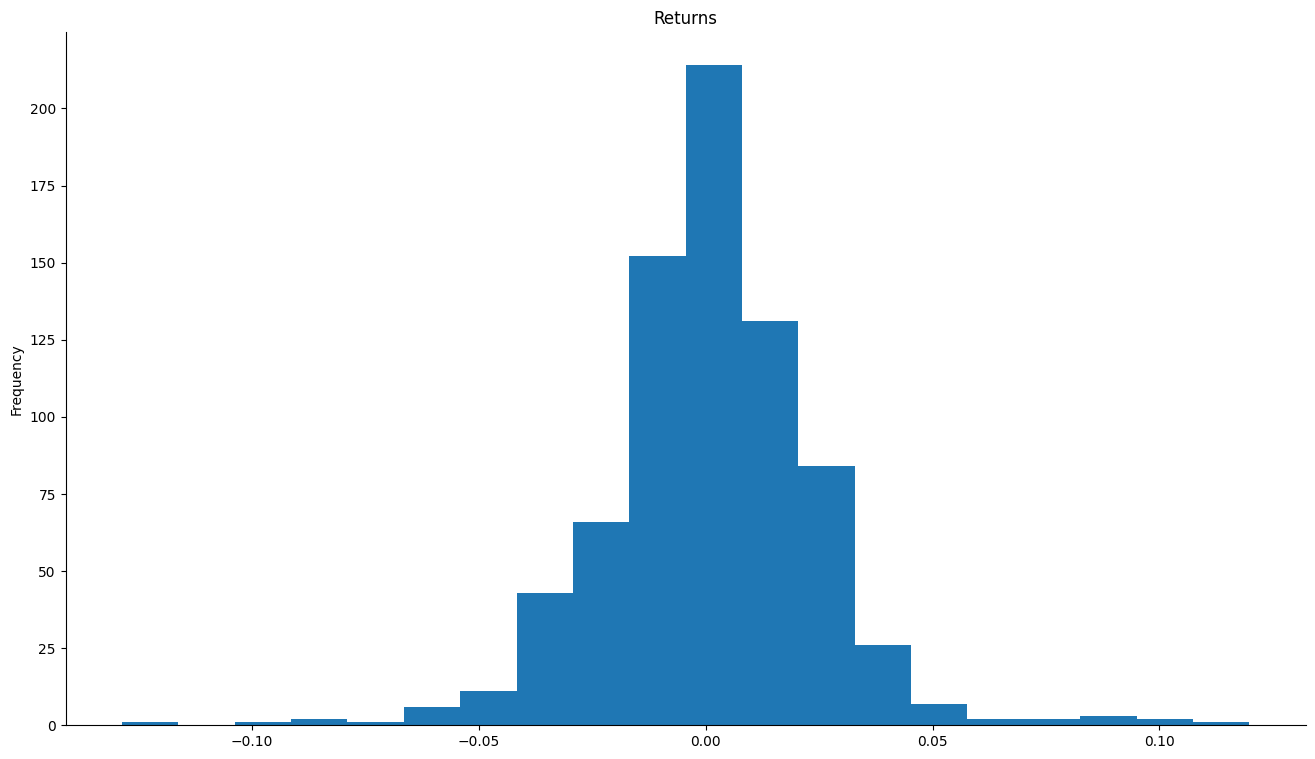

In [40]:
# @title Returns

from matplotlib import pyplot as plt
residuals_table['Returns'].plot(kind='hist', bins=20, title='Returns')
plt.gca().spines[['top', 'right',]].set_visible(False)

<h3>Returns</h3>

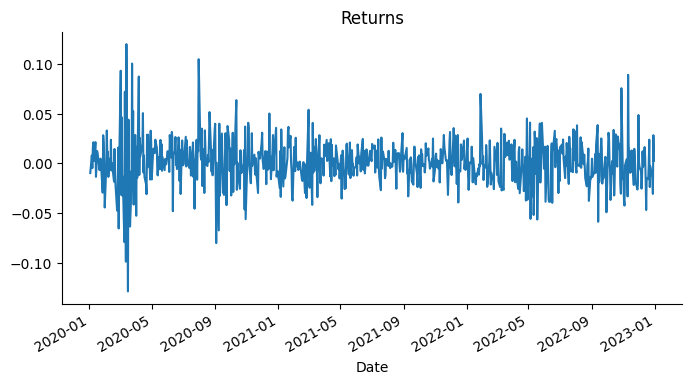

In [41]:
# @title Returns

from matplotlib import pyplot as plt
residuals_table['Returns'].plot(kind='line', figsize=(8, 4), title='Returns')
plt.gca().spines[['top', 'right']].set_visible(False)

In [42]:
# Breusch-Pagan test for heteroskedasticity
test_statistic, p_value, _, _ = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan test p-value: {p_value:.4f}")

Breusch-Pagan test p-value: 0.0003


In [43]:
from statsmodels.stats.diagnostic import het_white

# Perform White's test
white_test_stat, white_p_value, _, _ = het_white(model.resid, model.model.exog)
print(f"White's test p-value: {white_p_value}")

White's test p-value: 2.2585433847979665e-09


In [44]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Perform Goldfeld-Quandt test
gq_test_stat, gq_p_value, _ = het_goldfeldquandt(y, X)
print(f"Goldfeld-Quandt test p-value: {gq_p_value}")

Goldfeld-Quandt test p-value: 0.9999997362356773


Interpretation of the Test Results:

Breusch-Pagan Test (p-value: 0.0003):

The Breusch-Pagan test detects heteroskedasticity with a very low p-value (0.0003), indicating that heteroskedasticity is present.

Goldfeld-Quandt Test (p-value: 0.9999997):

A very high p-value (almost 1) suggests that the Goldfeld-Quandt test does not detect heteroskedasticity.

White’s Test (p-value: 2.2586e-09):

The White test’s extremely low p-value (close to 0) suggests strong evidence of heteroskedasticity.


Why Do We See Different Results?

Breusch-Pagan and White’s Tests are both detecting heteroskedasticity, as they consider different aspects of the data.
Goldfeld-Quandt Test, on the other hand, splits the data and checks for heteroskedasticity between the groups, which might not be as sensitive in this particular context.

Conclusion:
Despite the differing results from the Goldfeld-Quandt test, both the Breusch-Pagan and White’s tests provide strong evidence of heteroskedasticity in the Apple (AAPL) stock returns.

Below are the necessary steps to address the issues associated with heteroskedasticity:

1. Use Robust Standard Errors
Why: Heteroskedasticity distorts the standard errors in Ordinary Least Squares (OLS), leading to unreliable hypothesis testing (e.g., t-tests, F-tests) and confidence intervals.
How:
Apply heteroskedasticity-robust standard errors (e.g., White’s robust standard errors) to account for the non-constant variance in the residuals.
These robust standard errors allow valid statistical inference even in the presence of heteroskedasticity without altering the coefficient estimates.

In [45]:
# Fit OLS model with robust standard errors
model_robust = sm.OLS(y, X).fit(cov_type='HC3')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.449
Date:                Wed, 11 Sep 2024   Prob (F-statistic):              0.229
Time:                        01:30:07   Log-Likelihood:                 1769.6
No. Observations:                 755   AIC:                            -3535.
Df Residuals:                     753   BIC:                            -3526.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.462      0.1

Weighted Least Squares (WLS) Why: In cases of severe heteroskedasticity, it’s essential to give different weights to observations based on their variance. Observations with smaller variance should be given more weight, while those with higher variance should be down-weighted. How: Use Weighted Least Squares (WLS) to adjust for heteroskedasticity by incorporating the inverse of the variance as weights for each observation. This leads to more efficient estimates by accounting for non-constant variance in the data.

In [46]:
# Assuming you have an estimate of the variance (weights)
weights = 1 / np.var(model.resid)
model_wls = sm.WLS(y, X, weights=weights).fit()
print(model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.003
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.061
Date:                Wed, 11 Sep 2024   Prob (F-statistic):              0.151
Time:                        01:30:32   Log-Likelihood:                 1769.6
No. Observations:                 755   AIC:                            -3535.
Df Residuals:                     753   BIC:                            -3526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.849      0.0

Transforming the Data Why: In some cases, heteroskedasticity can be addressed by transforming the dependent variable (e.g., using the logarithm or square root of the dependent variable). This helps stabilize the variance and improve model fit. How: Apply transformations such as: Logarithmic transformation: Use log(Y) as the dependent variable if the variance increases with larger values of Y. Square root transformation: This is another transformation that can stabilize variance if the relationship between Y and the independent variables is non-linear.

In [47]:
# Log transformation of the dependent variable
y_log = np.log(y)
model_log = sm.OLS(y_log, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 11 Sep 2024   Prob (F-statistic):                nan
Time:                        01:31:08   Log-Likelihood:                    nan
No. Observations:                 755   AIC:                               nan
Df Residuals:                     753   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<h1>Non Stationarity

<h3>Demonstration</h3>

In [50]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import abline_plot
import scipy.stats as stats
from scipy.stats import kurtosis, skewnorm
from scipy.stats import iqr
from scipy.stats import skew
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression
from statsmodels .tsa.stattools import adfuller
import yfinance as yfin
import math
import QuantLib as ql


plt.rcParams["figure.figsize"] = (10, 7)

In [51]:
# Download the dataset of 8-year NVIDIA stock data from Yahoo finance
NV = yfin.download('NVDA', start='2015-01-01')[["Adj Close"]]
raw_data = NV.rename(columns={"Date": "Date","Adj Close": "Price"})
raw_data.head()

[*********************100%%**********************]  1 of 1 completed


Price
Date                
2015-01-02  0.483218
2015-01-05  0.475056
2015-01-06  0.460654
2015-01-07  0.459453
2015-01-08  0.476737

<h3>Diagram</h3>

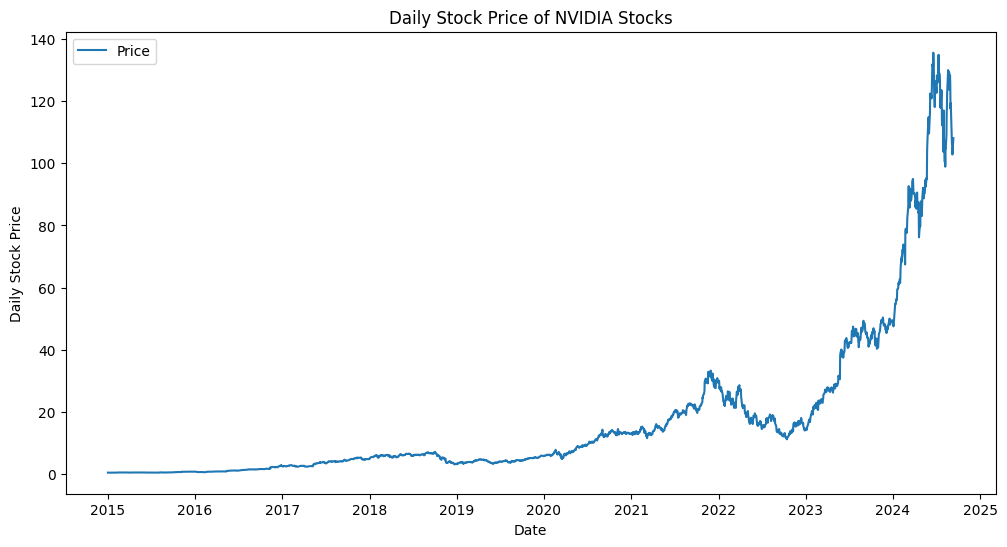

In [52]:
plt.figure(figsize=(12, 6))

plt.plot(raw_data.index, raw_data["Price"], label='Price')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Stock Price")
plt.title("Daily Stock Price of NVIDIA Stocks")
plt.show()

<h3>Diagnosis</h3>

To diagnose the challenge run Dickey-Fuller Test which test for non-stationarity. The null hypothesis impies non-stationary, while the alternative hypothesis indicates stationarity. For p-value < 0.05, we reject null hypothesis, otherwise we accept the null hypotheis.

Additionally, the Augmened Dickey Fuller's statistic also help to test for nonstatiornarity. A

<h3>Augmented Dickey-Fuller (ADF) Test

In [54]:
# Test for stationarity 
result = adfuller(raw_data.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value (Stock Price): {result[1]}')
print(f'Critical Values (Stock Price): {result[4]}')

ADF Statistic: 1.7885094717085006
p-value (Stock Price): 0.9983259530817212
Critical Values (Stock Price): {'1%': -3.4330662982661715, '5%': -2.8627400264482548, '10%': -2.5674088238838864}


Since p-value is appromixately 1 and ADF statistic is very close to 1, we can confirm that Daily Stock Price series is non-stationary.

<h3>Damage</h3>

The most obvious damage observed from the non-stationary processes is noticed on ACF AND PACF plots of data

<h3>ACF & PACF Plot</h3>

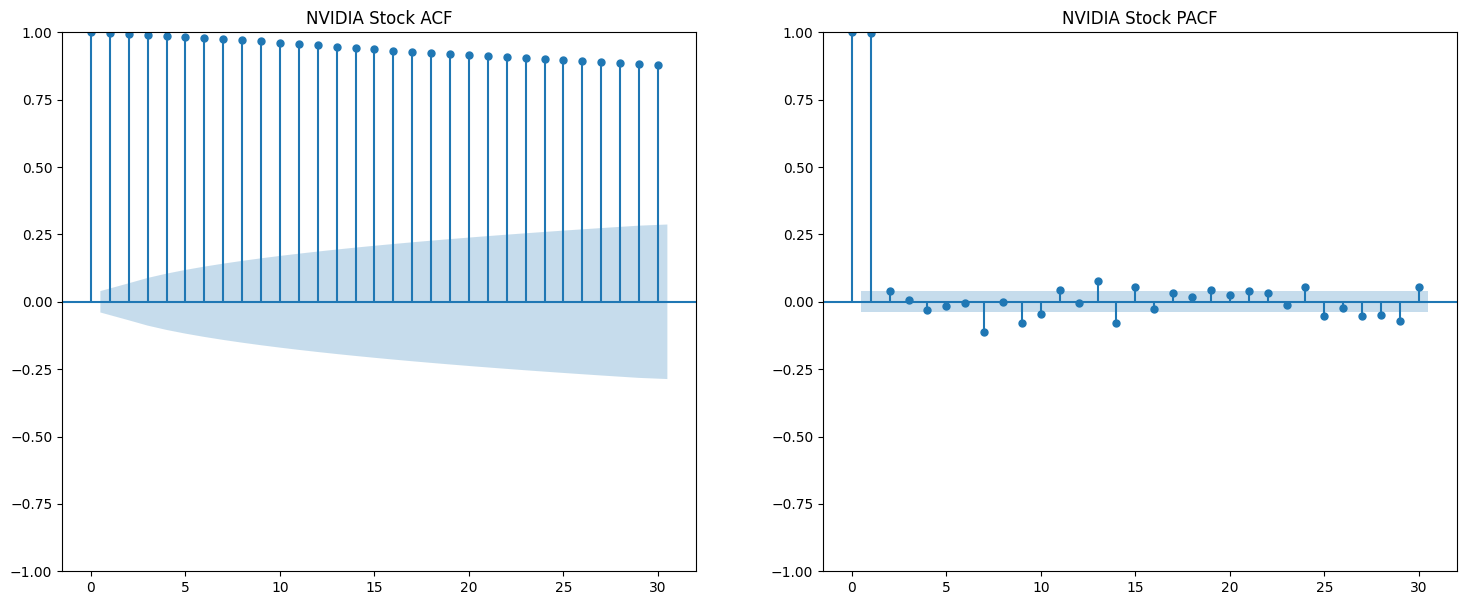

In [55]:
# ACF Plots for GOOGLE, U.S. UST10Y and DXY_R
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sm.graphics.tsa.plot_acf(raw_data["Price"], title="NVIDIA Stock ACF", lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(raw_data["Price"], title="NVIDIA Stock PACF", lags=30, ax=ax[1])
plt.show()

NVIDIA stock has high and slowly declining autocorrelations in the ACF plots, which usually means there is some sort of trend in the time series. It also means these time series are not stationary. THE PACF show changing trend which is also indicative of a non-stationary time series

<h3>Directions

There are two mains for removing non-stationarity in time series:

1. To remove trends.
2. To remove variation

<h3>Removing Trends</h3>

<h3>Detrending using a Regression Model

In [56]:
# Detrend
timeTrend = np.linspace(1, len(raw_data.Price), len(raw_data.Price))
timeTrend = sm.add_constant(timeTrend)

# Fit OLS
model = sm.OLS(raw_data.Price, timeTrend).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     2735.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:39:44   Log-Likelihood:                -10435.
No. Observations:                2438   AIC:                         2.087e+04
Df Residuals:                    2436   BIC:                         2.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.9381      0.709    -21.082      0.000     -16.328     -13.549
x1             0.0263      0.001     52.300      0.000       0.025       0.027
==============================================================================
Omnibus:                     1219.323   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7551.815
Skew:                           2.337   Prob(JB):                         0.00
Kurtosis:                      10.245   Cond. No.                     2.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

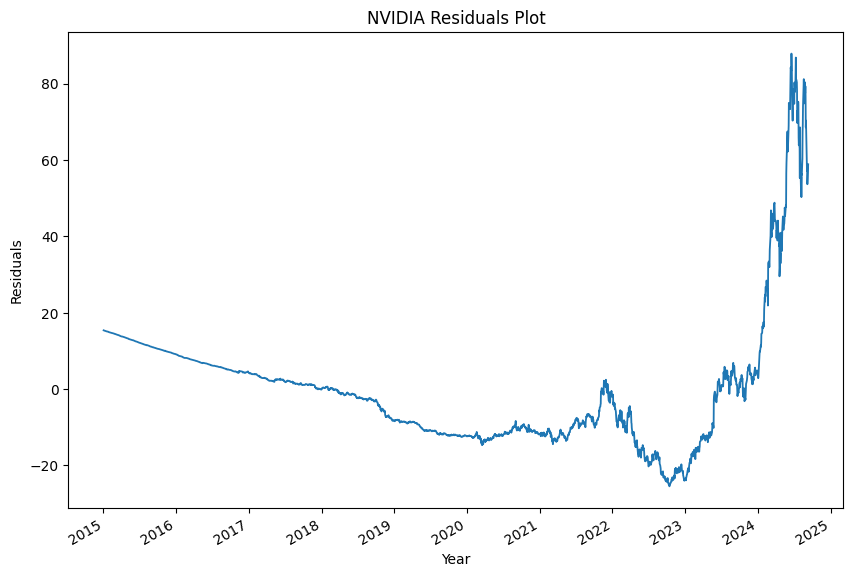

In [57]:
# Plot residuals
raw_data_res = model.resid
raw_data_res.plot(linewidth=1.3, xlabel="Year", ylabel="Residuals")
plt.title("NVIDIA Residuals Plot")
plt.show()

In [58]:
#test residuals results results using ADF test
result_res = adfuller(raw_data_res.dropna())
print(f'ADF Statistic: {result_res[0]}')
print(f'p-value (Stock Price): {result_res[1]}')
print(f'Critical Values (Stock Price): {result_res[4]}')

ADF Statistic: -0.0206018643995828
p-value (Stock Price): 0.9567948010597279
Critical Values (Stock Price): {'1%': -3.4330662982661715, '5%': -2.8627400264482548, '10%': -2.5674088238838864}


The ADF test above show that detrending using a regression could reduce the test statisitic but could not reduce the p-value, hence the data series is non-stationary.

We move on to using Differencing method.

<h3>Detrend using Differencing Method

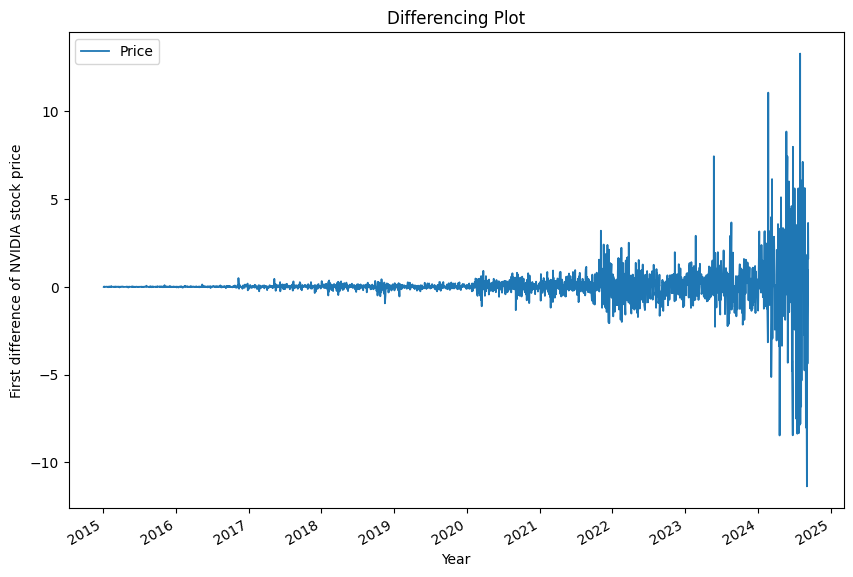

In [59]:
# Plot First Difference of NVIDIA Stock Price
raw_data.diff().plot(
    linewidth=1.3, xlabel="Year", ylabel="First difference of NVIDIA stock price"
)
plt.title('Differencing Plot')
plt.show()

The figure above shows that first differencing indeed helped to reduce variation as the time series is now differenced around time 0. However, the series became more volatile in the recent movements (2024 period).

In [60]:
#test first difference results using ADF test
result_diff = adfuller(raw_data.diff().dropna())
print(f'ADF Statistic: {result_diff[0]}')
print(f'p-value (Stock Price): {result_diff[1]}')
print(f'Critical Values (Stock Price): {result_diff[4]}')

ADF Statistic: -8.09492538605166
p-value (Stock Price): 1.3470520116865712e-12
Critical Values (Stock Price): {'1%': -3.4330662982661715, '5%': -2.8627400264482548, '10%': -2.5674088238838864}


The ADF test statistic first diference results is negative and the p-value very small (< 0.05). We can reject the hypothesis and confirm removal of non-stationarirty (i.e the series is now stationary.

Hence there is no need for further transformation of the series

<h3>ACF and PACF Plots for First Difference of NVIDIA Stock Price

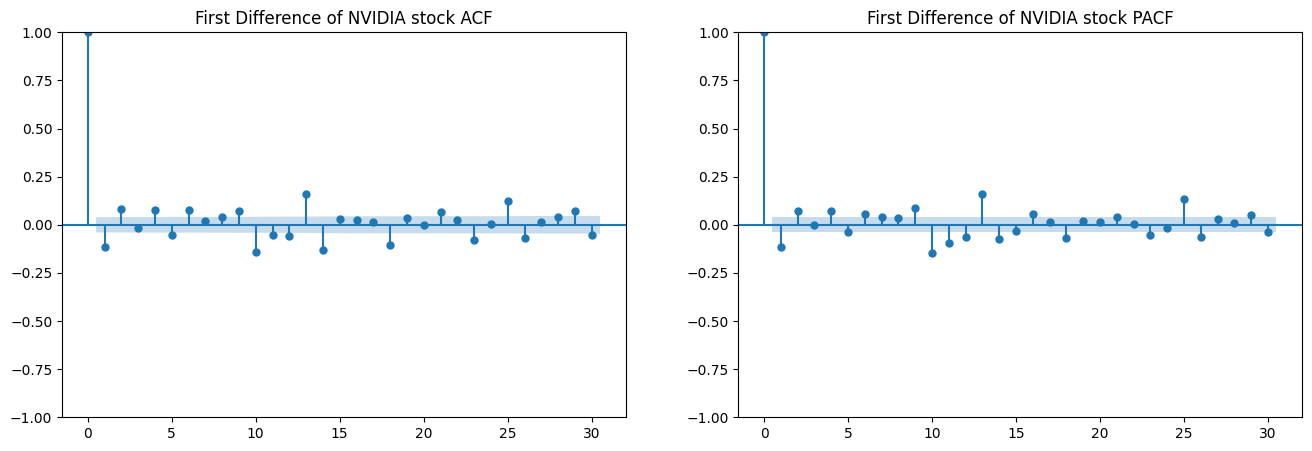

In [61]:
#ACF and PACF Plots for First Difference of Logged Google Stock Price
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(
    raw_data.diff().dropna(),
    title="First Difference of NVIDIA stock ACF",
    lags=30,
    ax=ax1,
)
sm.graphics.tsa.plot_pacf(
    raw_data.diff().dropna(),
    title="First Difference of NVIDIA stock PACF",
    lags=30,
    ax=ax2,
)
plt.show()

From figure 9, we see that for NVIDIA stock lag13, and lag25 are positive and significant on both ACF and PACF plots while lag10 and lag14 are negative on the PACF plot.

While further series transformation can be carried out to further reduce variation, our goal to remove non-stationarity has been achieved, hence no need further modeling.

<h1>Over-reliance on normality</h1>

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import shapiro, kstest, anderson
from statsmodels.stats.diagnostic import normal_ad

In [63]:
df = pd.read_excel('Dataset/Data.xlsx')
df.set_index("Date", inplace = True)
column = ['Crude_Oil']
df = df[column]
# df = df.iloc[:, :-1]
df.head()

Crude_Oil
Date                 
1960-01-01       1.63
1960-02-01       1.63
1960-03-01       1.63
1960-04-01       1.63
1960-05-01       1.63

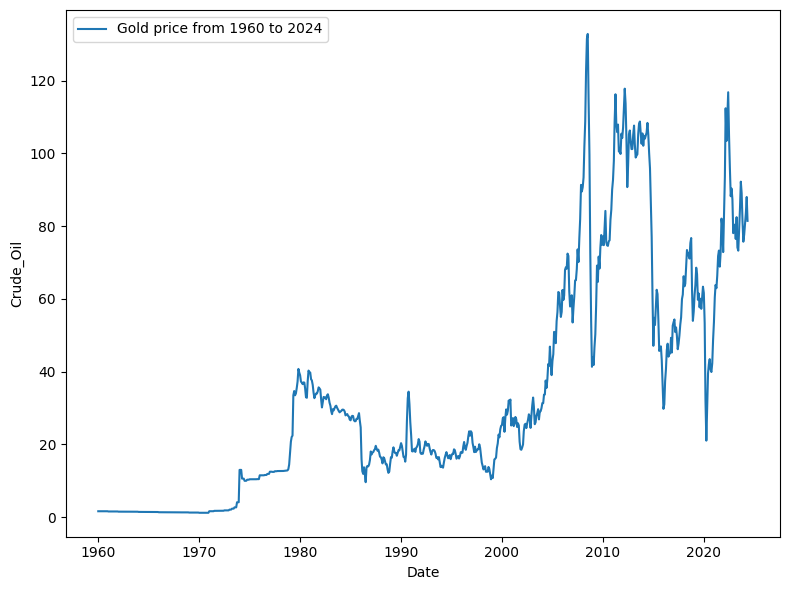

In [64]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y = df['Crude_Oil'], label='Gold price from 1960 to 2024')
plt.tight_layout()
plt.show()

<h3>Volatility of Crude Oil</h3>

In [65]:
# Returns 
df_pct = df.pct_change()
df_pct = df_pct.dropna()
df_pct.shape

(772, 1)

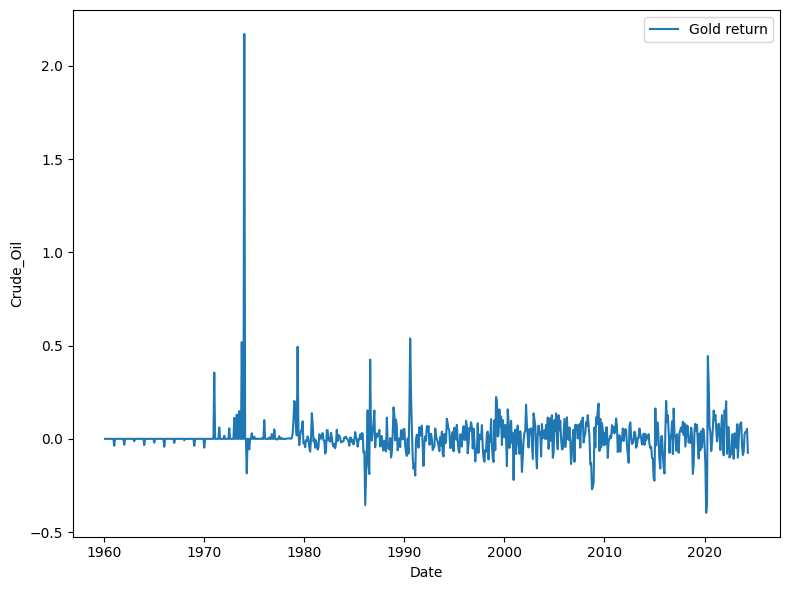

In [66]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df_pct.index, y = df_pct['Crude_Oil'], label='Gold return')
plt.tight_layout()
plt.show()

In [67]:
shapiro_stat, shapiro_p_value = shapiro(df_pct)
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p_value}')

Shapiro-Wilk Test: Statistic=0.5459447932439254, p-value=1.451663095734442e-40


In [68]:
kstest_stat, kstest_p_value = kstest(df_pct, 'norm', args=(df_pct.mean(), df_pct.std()))
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_stat}, p-value={kstest_p_value}')

Kolmogorov-Smirnov Test: Statistic=[0.16314783], p-value=[2.01062263e-18]


<h3>Distribution of Crude Oil</h3>

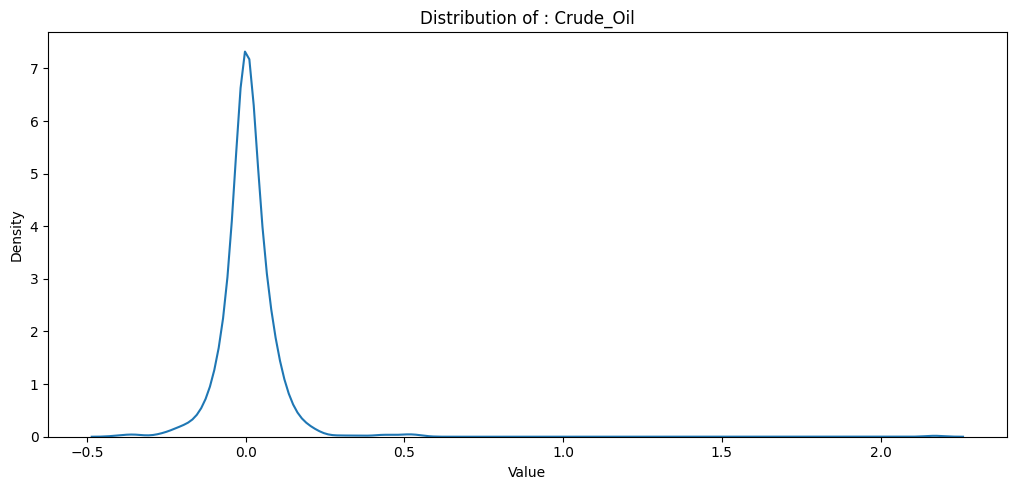

In [69]:
num_column = len(df.columns)
num_row_per_plot = 2
num_row = (num_column + num_row_per_plot - 1) // num_row_per_plot
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df_pct.columns):
    sns.kdeplot(df_pct[column], ax=axes[i])
    axes[i].set_title(f'Distribution of : {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig('Dist of Crude oil.png', dpi=300)
plt.show()

In [70]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(df_pct)
df = pd.DataFrame(transformed_data, index = df_pct.index, columns=df_pct.columns)
df

Crude_Oil
Date                 
1960-02-01  -0.014715
1960-03-01  -0.014715
1960-04-01  -0.014715
1960-05-01  -0.014715
1960-06-01  -0.014715
...               ...
2024-01-01   0.287758
2024-02-01   0.414380
2024-03-01   0.416529
2024-04-01   0.594360
2024-05-01  -0.988740

[772 rows x 1 columns]

<h3>Yeo-Johnson Transformation - To make distribution normal

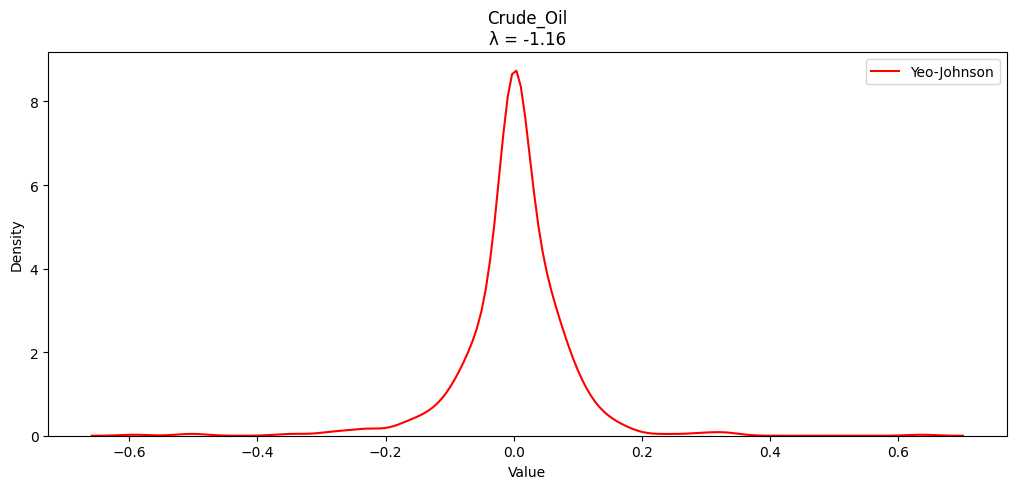

In [76]:
from scipy import stats

fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df_pct.columns):
    transformed_data, lambda_param = stats.yeojohnson(df_pct[column])
    sns.kdeplot(transformed_data, ax=axes[i], color='red', label='Yeo-Johnson')
    axes[i].set_title(f'{column}\nλ = {lambda_param:.2f}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# plt.savefig('Distibution of Crude Oil after Yeo Johnson Transformation.png', dpi=300)
plt.tight_layout()
plt.show()

<h3>Bootstrap </h3>

In [72]:
from sklearn.utils import resample
import numpy as np

def bootstrap(data, n_iterations=1000, statistic=np.mean):
    stats = []
    for _ in range(n_iterations):
        sample = resample(data, replace=True)
        stats.append(statistic(sample))
    return np.percentile(stats, [2.5, 97.5]) 

ci_crude_oil = bootstrap(df['Crude_Oil'])
print("95% confidence interval using bootstrap for Crude Oil: ", ci_crude_oil)

95% confidence interval using bootstrap for Crude Oil:  [-0.06471961  0.07275293]


<h3>Median-based Approach</h3>

In [73]:
median_crude_oil = df['Crude_Oil'].median()
print(f"Median of Crude Oil Prices: {median_crude_oil}")

Median of Crude Oil Prices: -0.014715393825367467


<h3>Huber Regressor (Robust Estimation)</h3>

In [74]:
from sklearn.linear_model import HuberRegressor
import numpy as np
from sklearn.model_selection import train_test_split

X = np.arange(len(df)).reshape(-1, 1)
y = df['Crude_Oil'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
huber = HuberRegressor()
huber.fit(X_train, y_train)
y_pred = huber.predict(X_test)

print("Huber Regressor Coefficients:", huber.coef_)

Huber Regressor Coefficients: [0.00029772]


In [75]:
from sklearn.metrics import mean_squared_error
print("MSE of Huber Regressor:", mean_squared_error(y_test, y_pred))

MSE of Huber Regressor: 1.0145190694668318
